**Toy examples**

In this part of the practical session, you will play with some toy data to better understand the classification algorithms seen this morning.

Please answer all questions 

**Deadline**: Upload this notebook, the one about Emotion Recognition and the answers to the theoretical questions to E-Campus. Please verify the exact deadline on E-Campus.

Let's first load the needed packages.

In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt  # for plots
from matplotlib.colors import ListedColormap
from matplotlib import rc

import seaborn as sns
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, accuracy_score
import time

%matplotlib inline
np.random.seed(seed=666)

Here, we define some functions useful for generating and plotting the data

In [2]:
def gaussian_data_generation(n, mean, cov, noise_std):
   # create data which follows a multivariate Gaussian distribution
   # a white (Gaussian) noise is then added to the data
    
    assert cov.shape[0] == cov.shape[1], "Please use only square covariance matrix"    
    assert len(mean) == cov.shape[0], "the dimension of the mean should be equal to the dimension of the covariance matrix"
    
    X = np.random.multivariate_normal(mean, cov, n) # actual data
    X = X + np.random.multivariate_normal(np.zeros(len(mean)), noise_std ** 2 *np.eye(len(mean)), n)  # we add white noise to the data     
   
    return X

def frontiere(f, X, y, step=50):
    # decision boundary of classifier f
    # construct cmap

    min_tot = np.min(X)
    max_tot = np.max(X)
    delta = (max_tot - min_tot) / step
    xx, yy = np.meshgrid(np.arange(min_tot, max_tot, delta),
                         np.arange(min_tot, max_tot, delta))
    z = np.array([f(vec) for vec in np.c_[xx.ravel(), yy.ravel()]])
    z = z.reshape(xx.shape)
    labels = np.unique(z)
    color_blind_list = sns.color_palette("colorblind", labels.shape[0])
    sns.set_palette(color_blind_list)
    my_cmap = ListedColormap(color_blind_list)
    plt.imshow(z, origin='lower', extent=[min_tot, max_tot, min_tot, max_tot],
               interpolation="mitchell", alpha=0.80, cmap=my_cmap)

    ax = plt.gca()
    cbar = plt.colorbar(ticks=labels)
    cbar.ax.set_yticklabels(labels)

    k = np.unique(y).shape[0]
    color_blind_list = sns.color_palette("colorblind", k)
    for i, label in enumerate(y):
        plt.scatter(X[i, 0], X[i, 1], c=[color_blind_list[int(y[i])]],
                    s=80, marker=symlist[int(label)])
    plt.ylim([min_tot, max_tot])
    plt.xlim([min_tot, max_tot])
    ax.get_yaxis().set_ticks([])
    ax.get_xaxis().set_ticks([])
    
def class_int_round(z, n_class):
    # rounding needed to go from real to integer values 
    output = np.round(z).astype(int)
    if isinstance(z, np.ndarray):
        j = z < 0
        output[j] = 0
        k = z > n_class - 1
        output[k] = n_class - 1
    else:
        if output < 0:
            output = 0
        else:
            if output > n_class - 1:
                output = n_class - 1
    return output

The next function is the one you will use to crete the toy data. You can choose among three scenarios: 2, 3 or 4 classes. Each class is composed of 2D points sampled from a multivariate Gaussian distribution. You can choose the number of samples, average and covariance matrix for each class. 

In [3]:
def generate_scenario(n_classes=3):
    
    if n_classes == 2:
        # Example with 2 classes
        n_0=80
        mean_0 = [0, 0]        
        cov_0 = np.array([[1, 0.1], [0.1, 0.9]])
        X_0=gaussian_data_generation(n_0, mean_0, cov_0, 0.1)
        y_0=np.zeros(n_0)
        
        n_1=80
        mean_1 = [3, 2]
        cov_1 = np.array([[0.1, 0], [0, 0.5]])
        X_1=gaussian_data_generation(n_1, mean_1, cov_1, 0.1)
        y_1=np.ones(n_1)
        
        X=np.concatenate((X_0,X_1))
        y=np.concatenate((y_0,y_1))
        
    elif n_classes == 3:
        # Example with 3 classes
        n_0=80
        mean_0 = [0, 0]        
        cov_0 = np.array([[1, 0.1], [0.1, 0.9]])
        X_0=gaussian_data_generation(n_0, mean_0, cov_0, 0.1)
        y_0=np.zeros(n_0)
        
        n_1=80
        mean_1 = [2, 2]
        cov_1 = np.array([[0.1, 0], [0, 0.5]])
        X_1=gaussian_data_generation(n_1, mean_1, cov_1, 0.1)
        y_1=np.ones(n_1)
        
        n_2=80
        mean_2 = [3, 3]
        cov_2 = np.array([[0.5, 0.1], [0.1, 1]])
        X_2=gaussian_data_generation(n_2, mean_2, cov_2, 0.1)
        y_2=2*np.ones(n_2)
        
        X=np.concatenate((X_0,X_1,X_2))
        y=np.concatenate((y_0,y_1,y_2))
    elif n_classes == 4:
        # Example with 4 classes
        n_0=80
        mean_0 = [0, 0]        
        cov_0 = np.array([[1, 0.1], [0.1, 0.9]])
        X_0=gaussian_data_generation(n_0, mean_0, cov_0, 0.1)
        y_0=np.zeros(n_0)
        
        n_1=80
        mean_1 = [3, 3]
        cov_1 = np.array([[0.1, 0], [0, 0.5]])
        X_1=gaussian_data_generation(n_1, mean_1, cov_1, 0.1)
        y_1=np.ones(n_1)
        
        n_2=80
        mean_2 = [0, 3]
        cov_2 = np.array([[0.5, 0.1], [0.1, 1]])
        X_2=gaussian_data_generation(n_2, mean_2, cov_2, 0.1)
        y_2=2*np.ones(n_2)
        
        n_3=80
        mean_3 = [3, 0]
        cov_3 = np.array([[0.9, 0.15], [0.15, 0.8]])
        X_3=gaussian_data_generation(n_3, mean_3, cov_3, 0.1)
        y_3=3*np.ones(n_3)
        
        X=np.concatenate((X_0,X_1,X_2,X_3))
        y=np.concatenate((y_0,y_1,y_2,y_3))  

    return X, y

Let's choose a scenario and generate some data

In [29]:
######## PARAMETER TO CHOOSE THE SCENARIO (number of classes) #######
n_classes=4
#####################################################################

X, y = generate_scenario(n_classes)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

Let's plot the data

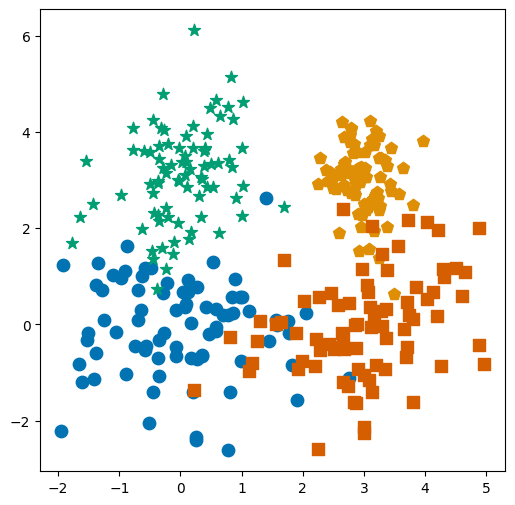

In [17]:
fig1 = plt.figure(figsize=(6, 6))
ax = plt.gca()
min_tot = np.min(X)
max_tot = np.max(X)
symlist = ['o', 'p', '*', 's', '+', 'x', 'D', 'v', '-', '^']
k = np.unique(y).shape[0]
color_blind_list = sns.color_palette("colorblind", k)
for i, label in enumerate(y):
    plt.scatter(X[i, 0], X[i, 1], c=[color_blind_list[int(y[i])]],
                s=80, marker=symlist[int(label)])
#ax.get_yaxis().set_ticks([])
#ax.get_xaxis().set_ticks([])

As first classifier, we can use a simple linear regression where we  transform in integers the predictions.

 **Question**: look at the function 'class_int_round'. Explain what it does.

  **Answer:** The class_int_round function accepts either a vector of real numbers or a single real number as input. When provided with a vector, it returns a vector of integers where each element is the rounded value of the corresponding element of the input vector. These rounded values fall within the range [0, n-1], where n is the length of the input vector. If the input is a single real number, the function returns the rounded value of that number within the same range [0, n-1].

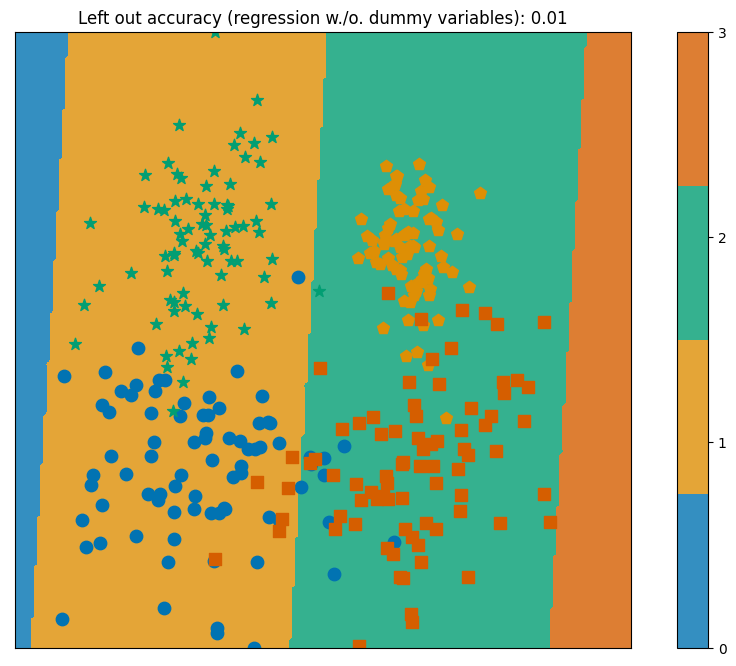

In [18]:
##############################################################################
# Naive linear regression on raw observations
##############################################################################

resolution_param = 200  # 500 for nice plotting, 50 for fast version
regr = LinearRegression()
regr.fit(X_train, y_train)
y_pred_test = class_int_round(regr.predict(X_test), n_classes)

# Plotting part
fig0 = plt.figure(figsize=(12, 8))
title = "Left out accuracy (regression w./o. dummy variables)" + \
        ": {:.2f}".format(accuracy_score(y_test, y_pred_test))
plt.title(title)

def f(xx):
    """Classifier"""
    return class_int_round(regr.predict(xx.reshape(1, -1)), n_classes)
frontiere(f, X, y, step=resolution_param)

plt.show()

Instead of using this simple strategy, we can also use a *OneHotEncoder*.

**Question**: Do you see any difference in the resulting decision boundaries ? Which is the best strategy in your opinion ? Why ?

**Answer**

In this specific scenario, employing *OneHotEncoder* yields superior results, as evidenced by the higher accuracy scores of both classifications. Generally, one-hot encoding proves to be a more effective strategy when compared to ordinal encoding, primarily because it offers a more precise representation of the data and mitigates issues associated with label order. This outcome likely reflects the advantages inherent in using dummy variables.

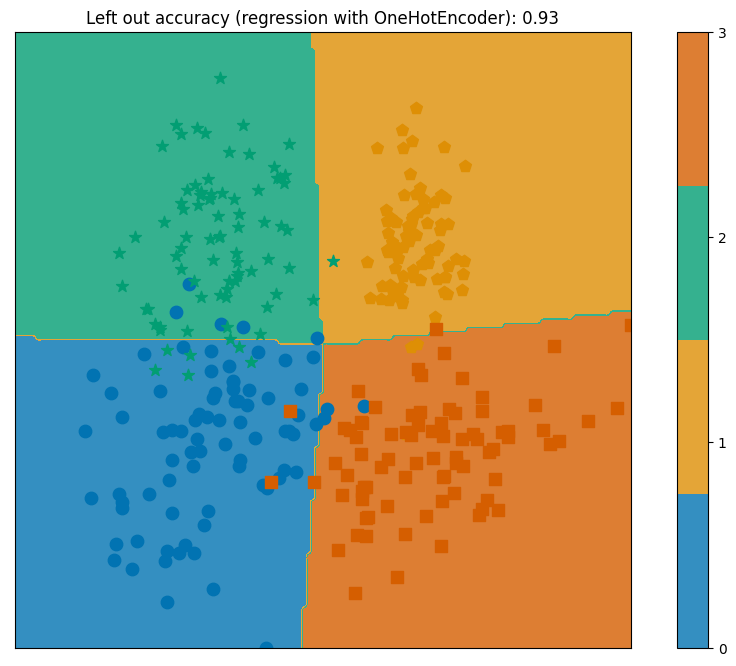

In [31]:
##############################################################################
# Naive linear regression on dummy variables (OneHotEncoder)
##############################################################################
resolution_param = 150  
enc = OneHotEncoder(categories='auto')
enc.fit(y_train.reshape(-1, 1))
Y = enc.transform(y_train.reshape(-1, 1)).toarray()
regr_multi = LinearRegression()
regr_multi.fit(X_train, Y)
proba_vector_test = regr_multi.predict(X_test)
y_pred_test = class_int_round(regr.predict(X_test), n_classes)

# performance evaluation on new dataset
y_pred_test = np.argmax(proba_vector_test, axis=1)
title = "Left out accuracy (regression with OneHotEncoder)" + \
        ": {:.2f}".format(accuracy_score(y_test, y_pred_test))

# Plotting part
fig1 = plt.figure(figsize=(12, 8))
plt.title(title)


def f(xx):
    """Classifier"""
    return np.argmax(regr_multi.predict(xx.reshape(1, -1)))
frontiere(f, X, y, step=resolution_param)

plt.show()

Let's use the other strategies seen this morning.

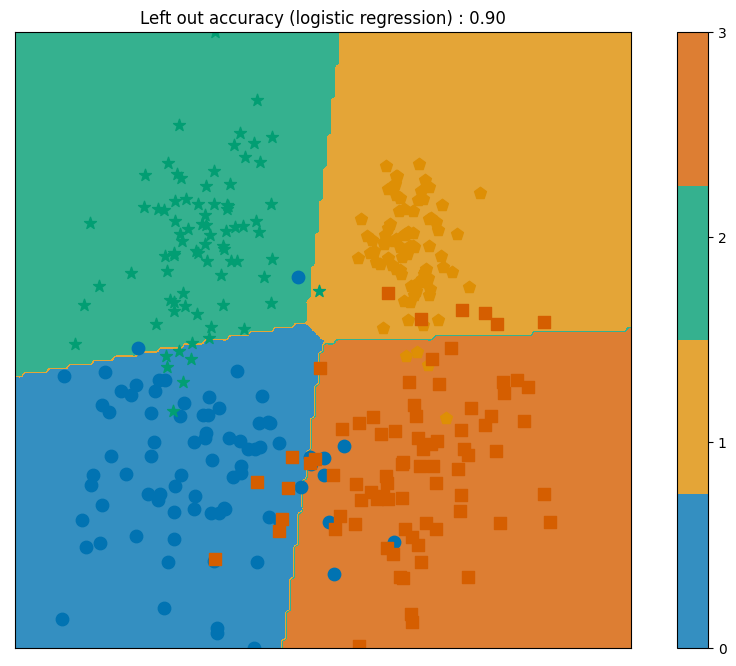

In [20]:
##############################################################################
# Logistic regression
##############################################################################
resolution_param = 150  
clf = LogisticRegression(solver='lbfgs',multi_class='ovr') # you can also try multi_class='multinomial', 
clf.fit(X_train, y_train)
y_logit_test = clf.predict(X_test)
title = "Left out accuracy (logistic regression) " + \
        ": {:.2f}".format(accuracy_score(y_test, y_logit_test))
fig2 = plt.figure(figsize=(12, 8))
plt.title(title)


def f(xx):
    """Classifier"""
    return int(clf.predict(xx.reshape(1, -1)))
frontiere(f, X, y, step=resolution_param)

plt.show()

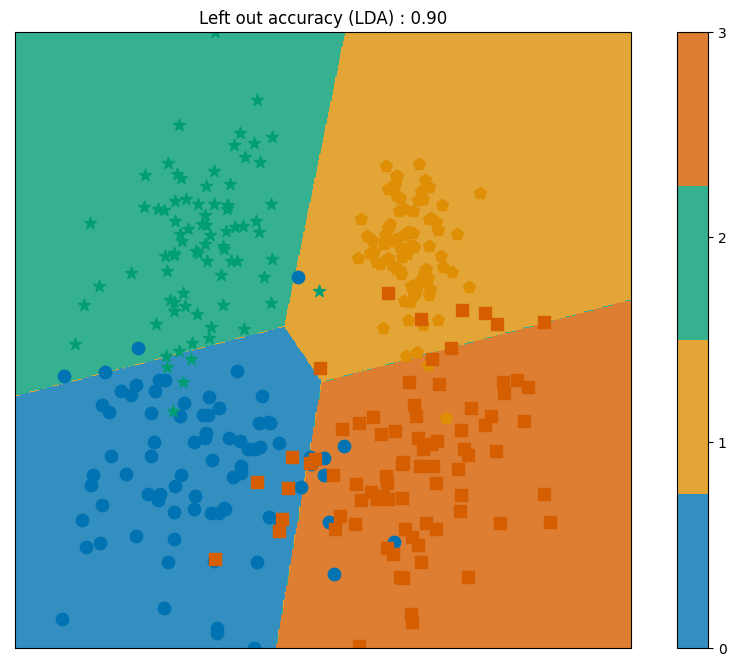

In [21]:
##############################################################################
# LDA
##############################################################################
resolution_param = 500 
clf_LDA = LinearDiscriminantAnalysis()
clf_LDA.fit(X_train, y_train)
y_LDA_test = clf_LDA.predict(X_test)

title = "Left out accuracy (LDA) " + \
        ": {:.2f}".format(accuracy_score(y_test, y_LDA_test))
fig2 = plt.figure(figsize=(12, 8))
plt.title(title)


def f(xx):
    """Classifier"""
    return int(clf_LDA.predict(xx.reshape(1, -1)))
frontiere(f, X, y, step=resolution_param)

plt.show()

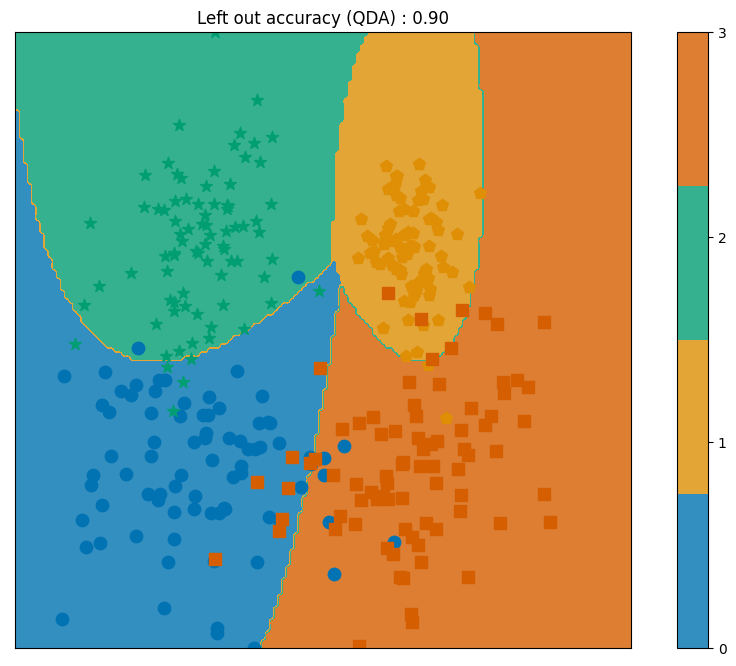

In [22]:
##############################################################################
# QDA
##############################################################################
resolution_param = 150 
clf_QDA = QuadraticDiscriminantAnalysis()
clf_QDA.fit(X_train, y_train)
y_QDA_test = clf_QDA.predict(X_test)
title = "Left out accuracy (QDA) " + \
        ": {:.2f}".format(accuracy_score(y_test, y_QDA_test))
fig2 = plt.figure(figsize=(12, 8))
plt.title(title)


def f(xx):
    """Classifier"""
    return int(clf_QDA.predict(xx.reshape(1, -1)))
frontiere(f, X, y, step=resolution_param)

plt.show()

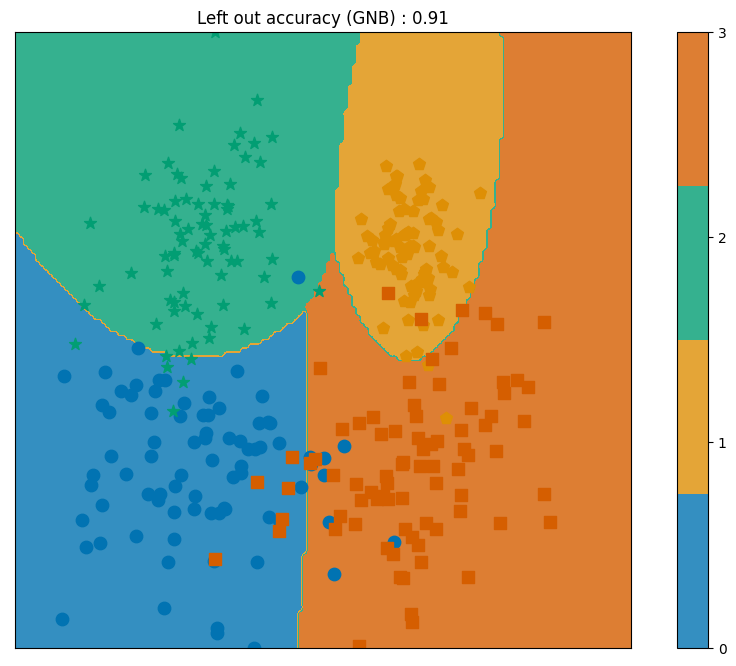

In [23]:
##############################################################################
# Naive Bayes 
##############################################################################
resolution_param = 150  
clf_GNB = GaussianNB()
clf_GNB.fit(X_train, y_train)

y_test_GNB = clf_GNB.predict(X_test)

title = "Left out accuracy (GNB) " + \
        ": {:.2f}".format(accuracy_score(y_test, y_test_GNB))
fig2 = plt.figure(figsize=(12, 8))
plt.title(title)


def f(xx):
    """Classifier"""
    return int(clf_GNB.predict(xx.reshape(1, -1)))
frontiere(f, X, y, step=resolution_param)

plt.show()

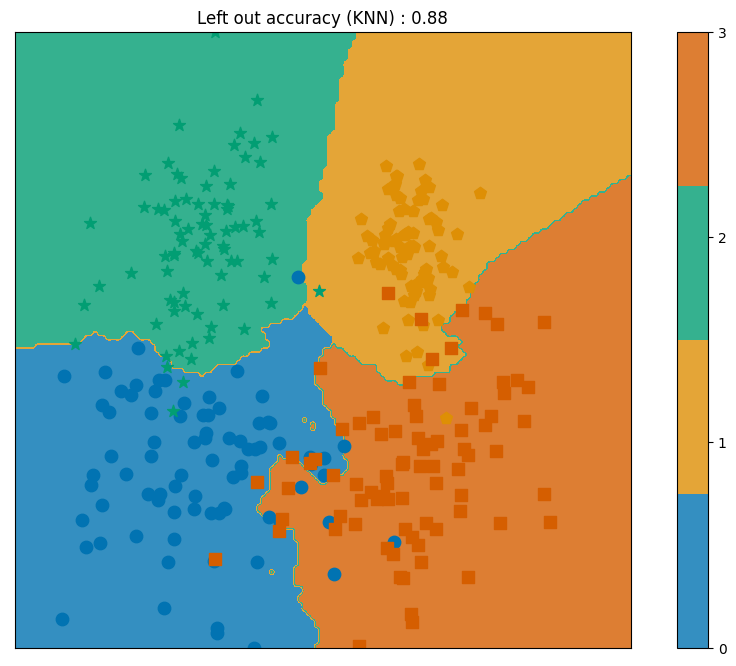

In [24]:
##############################################################################
# KNN
##############################################################################
resolution_param = 150  
clf_KNN = KNeighborsClassifier()
clf_KNN.n_neighbors=5

clf_KNN.fit(X_train, y_train)
y_KNN_test = clf_KNN.predict(X_test)

title = "Left out accuracy (KNN) " + \
        ": {:.2f}".format(accuracy_score(y_test, y_KNN_test))
fig2 = plt.figure(figsize=(12, 8))
plt.title(title)

def f(xx):
    """Classifier"""
    return int(clf_KNN.predict(xx.reshape(1, -1)))
frontiere(f, X, y, step=resolution_param)

plt.show()

**Questions**:


*   Describe the decision boundaries of the methods. Are all linear ?


**Answer**
The decision boundaries are not all linear. For the Naive Linear Regression (with and without One-hot encoding), Logistic Regression, and LDA, the decision boundaries are linear. However, for KNN, QDA, and GNB, they don't follow a linear pattern.

QDA and GNB follow a pattern similar to a quadratic form, while KNN does not follow a specific pattern.

These results were expected because different algorithms make different assumptions about the underlying data distributions and relationships between features and classes. Linear classifiers like Naive Linear Regression, Logistic Regression, and LDA assume that the decision boundaries separating classes are linear. On the other hand, non-linear classifiers like KNN, QDA, and GNB make more flexible assumptions, allowing them to capture complex relationships in the data. 

QDA explicitly models the covariance matrix for each class, allowing for quadratic decision boundaries, while GNB makes the assumption of feature independence but can still produce non-linear decision boundaries when the underlying data distributions are not Gaussian. KNN, being a non-parametric algorithm, makes no assumptions about the shape of the decision boundaries and instead relies on the distribution of data points in the feature space to classify new instances.
No, 
*   Using the following code, compare the computational time and the test accuracy of the different methods in the three scenarios. Comment the results.

**Answer**

Code Below.
Linear Discriminant Analysis (LDA) and Quadratic Discriminant Analysis (QDA) exhibit similar computational times and test accuracies, with both achieving a high accuracy of 0.91. This suggests that both linear and quadratic decision boundaries are effective in this dataset.

In contrast, the linear regression model without one-hot encoding yields a significantly lower test accuracy of 0.01, indicating poor performance. However, when one-hot encoding is applied, the accuracy improves drastically to 0.93, highlighting the importance of appropriate data preprocessing techniques.

Logistic Regression also achieves a test accuracy of 0.93, comparable to the performance with one-hot encoding. However, logistic regression requires substantially more computational time compared to the other classifiers, with a time of 0.051 seconds.

* (Optional) If you change the number of samples per class (both training and test), do the results vary ?

Code below.
Yes, as expected the results change a lot.

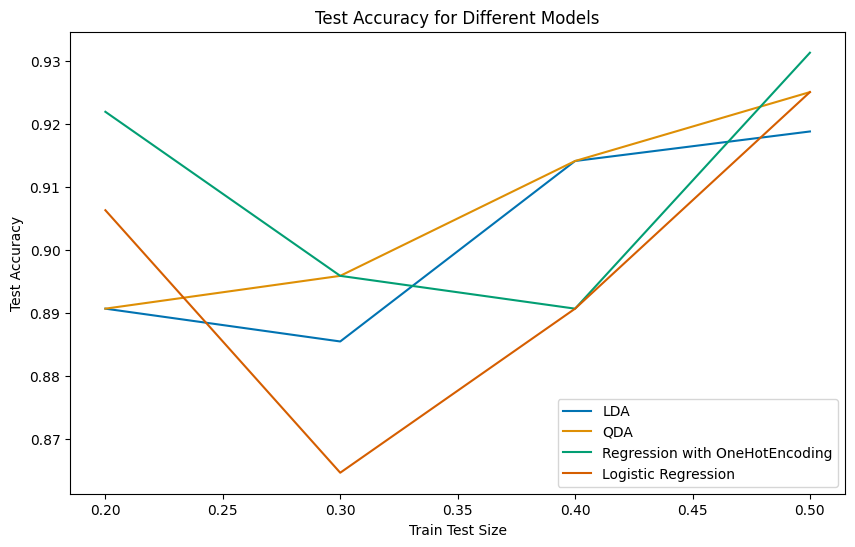



As we can see, there is a maximum of performance in 0.5(train_test_size), for the Regression with oneHot coding, and the worse for Logistic Regression at 0.3.



In [37]:
import time
from sklearn.metrics import accuracy_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import numpy as np

# Define the classifiers
classifiers = [
    ('LDA', LinearDiscriminantAnalysis()),
    ('QDA', QuadraticDiscriminantAnalysis()),
    ('Regression without OneHotEncoding', LinearRegression()),
    ('Regression with OneHotEncoding', LinearRegression()),  # Corrected typo here
    ('Logistic Regression', LogisticRegression())
]

# Define the results dictionary
results = {}

# Loop through the classifiers
for name, clf in classifiers:
    # Start the timer
    time_start = time.perf_counter()
    
    # Fit the classifier
    if name == 'Regression without OneHotEncoding':
        clf.fit(X_train, y_train)
        y_pred_test  = class_int_round(regr.predict(X_test), n_classes)
    elif name == 'Regression with OneHotEncoding':
        enc = OneHotEncoder(categories='auto')
        enc.fit(y_train.reshape(-1, 1))
        Y = enc.transform(y_train.reshape(-1, 1)).toarray()
        regr_multi = LinearRegression()
        regr_multi.fit(X_train, Y)
        proba_vector_test = regr_multi.predict(X_test)
        y_pred_test = class_int_round(regr.predict(X_test), n_classes)

        # performance evaluation on new dataset
        y_pred_test = np.argmax(proba_vector_test, axis=1)
    else:
        clf.fit(X_train, y_train)
        y_pred_test = clf.predict(X_test)
    
    # Predict on the test set
    
    # Calculate the computational time
    time_elapsed = (time.perf_counter() - time_start)
    
    # Calculate the test accuracy
    test_accuracy = accuracy_score(y_test, y_pred_test)
    
    # Store the results in the dictionary
    results[name] = {'Computational time': time_elapsed, 'Test accuracy': test_accuracy}

# Print the results
for name, result in results.items():
    print(name + ':')
    print('Computational time:', "%f" % result['Computational time'], 's')
    print('Test accuracy:', "%.2f" % result['Test accuracy'])
    print()


LDA:
Computational time: 0.009581 s
Test accuracy: 0.91

QDA:
Computational time: 0.006121 s
Test accuracy: 0.91

Regression without OneHotEncoding:
Computational time: 0.005193 s
Test accuracy: 0.01

Regression with OneHotEncoding:
Computational time: 0.009136 s
Test accuracy: 0.93

Logistic Regression:
Computational time: 0.051044 s
Test accuracy: 0.93



In [55]:
import time
from sklearn.metrics import accuracy_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import numpy as np

import matplotlib.pyplot as plt




# Define the classifiers
classifiers = [
    ('LDA', LinearDiscriminantAnalysis()),
    ('QDA', QuadraticDiscriminantAnalysis()),
    ('Regression without OneHotEncoding', LinearRegression()),
    ('Regression with OneHotEncoding', LinearRegression()),  # Corrected typo here
    ('Logistic Regression', LogisticRegression())
]

# Define the results dictionary
results = {}

# Define the train_test_size parameters
train_test_sizes = [0.2, 0.3, 0.4, 0.5]

# Loop through the train_test_sizes
for train_test_size in train_test_sizes:
    # Start the timer
    time_start = time.perf_counter()
    
    # Loop through the classifiers
    for name, clf in classifiers:
        # Split the data into training and test sets
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=train_test_size, random_state=42)
        
        # Fit the classifier
        if name == 'Regression without OneHotEncoding':
            clf.fit(X_train, y_train)
            y_pred_test  = class_int_round(regr.predict(X_test), n_classes)
        elif name == 'Regression with OneHotEncoding':
            enc = OneHotEncoder(categories='auto')
            enc.fit(y_train.reshape(-1, 1))
            Y = enc.transform(y_train.reshape(-1, 1)).toarray()
            regr_multi = LinearRegression()
            regr_multi.fit(X_train, Y)
            proba_vector_test = regr_multi.predict(X_test)
            y_pred_test = class_int_round(regr.predict(X_test), n_classes)

            # performance evaluation on new dataset
            y_pred_test = np.argmax(proba_vector_test, axis=1)
        else:
            clf.fit(X_train, y_train)
            y_pred_test = clf.predict(X_test)
        
        # Calculate the test accuracy
        test_accuracy = accuracy_score(y_test, y_pred_test)
        
        # Store the results in the dictionary
        if train_test_size not in results:
            results[train_test_size] = {}
        results[train_test_size][name] = test_accuracy
    
    # Calculate the computational time
    time_elapsed = (time.perf_counter() - time_start)
    
    # Store the computational time in the dictionary
    results[train_test_size]['Computational time'] = time_elapsed

# Print the results
for train_test_size, result in results.items():
    print('Train Test Size:', train_test_size)
    for name, accuracy in result.items():
        if name != 'Computational time':
            print(name + ':')
            print('Test accuracy:', "%.2f" % accuracy)
    print('Computational time:', "%f" % result['Computational time'], 's')




Train Test Size: 0.2
LDA:
Test accuracy: 0.89
QDA:
Test accuracy: 0.89
Regression without OneHotEncoding:
Test accuracy: 0.02
Regression with OneHotEncoding:
Test accuracy: 0.92
Logistic Regression:
Test accuracy: 0.91
Computational time: 0.052394 s
Train Test Size: 0.3
LDA:
Test accuracy: 0.89
QDA:
Test accuracy: 0.90
Regression without OneHotEncoding:
Test accuracy: 0.02
Regression with OneHotEncoding:
Test accuracy: 0.90
Logistic Regression:
Test accuracy: 0.86
Computational time: 0.050616 s
Train Test Size: 0.4
LDA:
Test accuracy: 0.91
QDA:
Test accuracy: 0.91
Regression without OneHotEncoding:
Test accuracy: 0.02
Regression with OneHotEncoding:
Test accuracy: 0.89
Logistic Regression:
Test accuracy: 0.89
Computational time: 0.046261 s
Train Test Size: 0.5
LDA:
Test accuracy: 0.92
QDA:
Test accuracy: 0.93
Regression without OneHotEncoding:
Test accuracy: 0.02
Regression with OneHotEncoding:
Test accuracy: 0.93
Logistic Regression:
Test accuracy: 0.93
Computational time: 0.035063 s


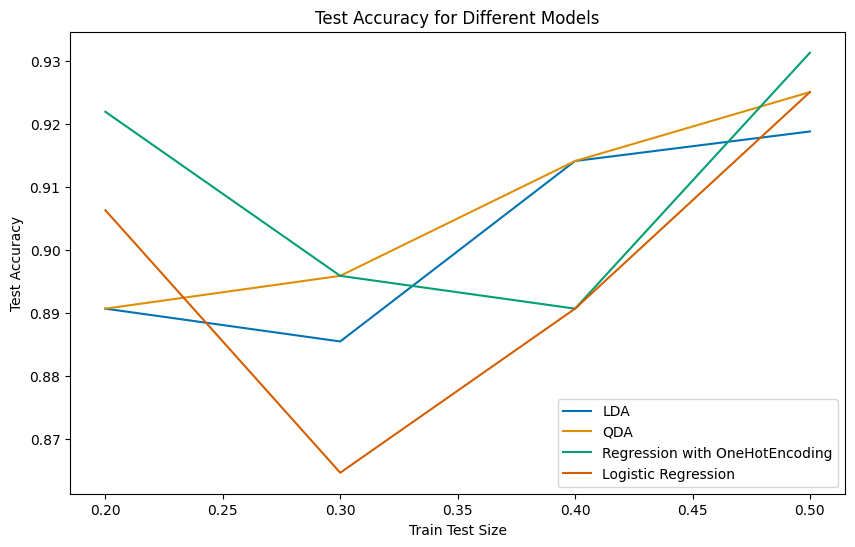

In [56]:
lda_accuracies = []
qda_accuracies = []
regression_wih_accuracies = []
logistic_regression_accuracies = []

# Loop through the train_test_sizes
for train_test_size, result in results.items():
    # Append the test accuracies to the corresponding lists
    lda_accuracies.append(result['LDA'])
    qda_accuracies.append(result['QDA'])
    regression_wih_accuracies.append(result['Regression with OneHotEncoding'])
    logistic_regression_accuracies.append(result['Logistic Regression'])

# Create a list of model names
model_names = ['LDA', 'QDA', 'Regression with OneHotEncoding', 'Logistic Regression']

# Plot the test accuracies for each model
plt.figure(figsize=(10, 6))
plt.plot(train_test_sizes, lda_accuracies, label='LDA')
plt.plot(train_test_sizes, qda_accuracies, label='QDA')
plt.plot(train_test_sizes, regression_wih_accuracies, label='Regression with OneHotEncoding')
plt.plot(train_test_sizes, logistic_regression_accuracies, label='Logistic Regression')
plt.xlabel('Train Test Size')
plt.ylabel('Test Accuracy')
plt.title('Test Accuracy for Different Models')
plt.legend()
plt.show()
